# U-net with VGG16 backbone and dilated convolutions

**Structure of the used model**
* U-net like structure with transfer learning:
  * Encoder: VGG 16 pre-trained on imagenet. Just the first 3 block used.
  * Botlleneck: Dilated convolutions
  * Decoder: U-net like, simplified

<img src="https://ws2.sinaimg.cn/large/006tNbRwgy1fxo4yeljodj30t80fwabp.jpg"
          align="center"
          width="800" />

## Load general packages. There some more package loading for the more specific tasks

In [0]:
colab = True

In [0]:
# for file handling
import os
from pathlib import Path

# Only if working from Google Colab
if colab:
    # Mount the Google Drive to reach its data
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir('/content/gdrive/My Drive')
    # making sure we used the newest versions
    !pip install --upgrade keras 
    !pip install --upgrade tensorflow

import sys
sys.path.append('Final_solution')    

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# for numeric calculations
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

# for data handling
import pandas as pd

# for plotting the preprocessed images and the output images and masks
from skimage.measure import find_contours
from skimage.util.montage import montage2d
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)

**log dictionary is used to make a log file after every parameters is collected**

In [0]:
log = {}

## Data handling and preprocessing

In [0]:
from data_utils import load_paths, make_split, make_generators
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


**Define the image parameters and the batch size**

In [0]:
image_parameters = dict(batch_size = 4,
                        image_size = (512, 512))
image_parameters['input_shape'] = image_parameters['image_size'] + (3,)

log['image_parameters'] = image_parameters

In [0]:
data_df = load_paths(root='ISIC2018')
train_df, valid_df, test_df = make_split(data_df, train_size=2080, valid_size=264)

print('images:', len(data_df),'train images:', len(train_df), 'valid images:', len(valid_df),'test images:', len(test_df))
data_df.head()

images: 2594 train images: 2080 valid images: 264 test images: 250


,image_path,image_id,image_filename,task1_path,task1_filename
2001,ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_...,ISIC_0000000,ISIC_0000000.jpg,ISIC2018/ISIC2018_Task1_Training_GroundTruth/I...,ISIC_0000000_segmentation.png
1998,ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_...,ISIC_0000001,ISIC_0000001.jpg,ISIC2018/ISIC2018_Task1_Training_GroundTruth/I...,ISIC_0000001_segmentation.png
1999,ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_...,ISIC_0000003,ISIC_0000003.jpg,ISIC2018/ISIC2018_Task1_Training_GroundTruth/I...,ISIC_0000003_segmentation.png
2004,ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_...,ISIC_0000004,ISIC_0000004.jpg,ISIC2018/ISIC2018_Task1_Training_GroundTruth/I...,ISIC_0000004_segmentation.png
2003,ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_...,ISIC_0000006,ISIC_0000006.jpg,ISIC2018/ISIC2018_Task1_Training_GroundTruth/I...,ISIC_0000006_segmentation.png


In [0]:
# Set the ImageDataGenerator arguments in a dictionary
data_gen_args = dict(data_format = 'channels_last',
                     preprocessing_function = lambda x: preprocess_input(x, data_format='channels_last', mode='tf'))
log['ImageDataGenerator_image_args'] = data_gen_args

# Use the same for the masks and images. (We use same seed value too.)
mask_gen_args = data_gen_args.copy()
mask_gen_args['preprocessing_function'] = lambda x: x/255.0
log['ImageDataGenerator_mask_args'] = mask_gen_args

In [0]:
# set the flow_from_directory arguments in a dictionary
image_flow_from_dataframe_args = dict(seed = 999,
                                      class_mode=None,
                                      batch_size=image_parameters['batch_size'],
                                      x_col='image_filename',
                                      color_mode = 'rgb',
                                      target_size = image_parameters['image_size'])
log['FlowFromDataframe_image_args'] = image_flow_from_dataframe_args

# use the same arguments for the masks and images. (We use same seed value too.)
mask_flow_from_dataframe_args = image_flow_from_dataframe_args.copy()
mask_flow_from_dataframe_args['x_col'] = 'task1_filename'
mask_flow_from_dataframe_args['color_mode'] = 'grayscale'
log['FlowFromDataframe_mask_args'] = mask_flow_from_dataframe_args

In [0]:
train_generator, valid_generator, test_generator = make_generators(data_gen_args, mask_gen_args, image_flow_from_dataframe_args, mask_flow_from_dataframe_args, train_df, valid_df, test_df)

Found 2080 images.
Found 2080 images.
Found 264 images.
Found 264 images.
Found 250 images.
Found 250 images.


image (4, 512, 512, 3) float32 -1.0 1.0
mask (4, 512, 512, 1) float32 0.0 1.0


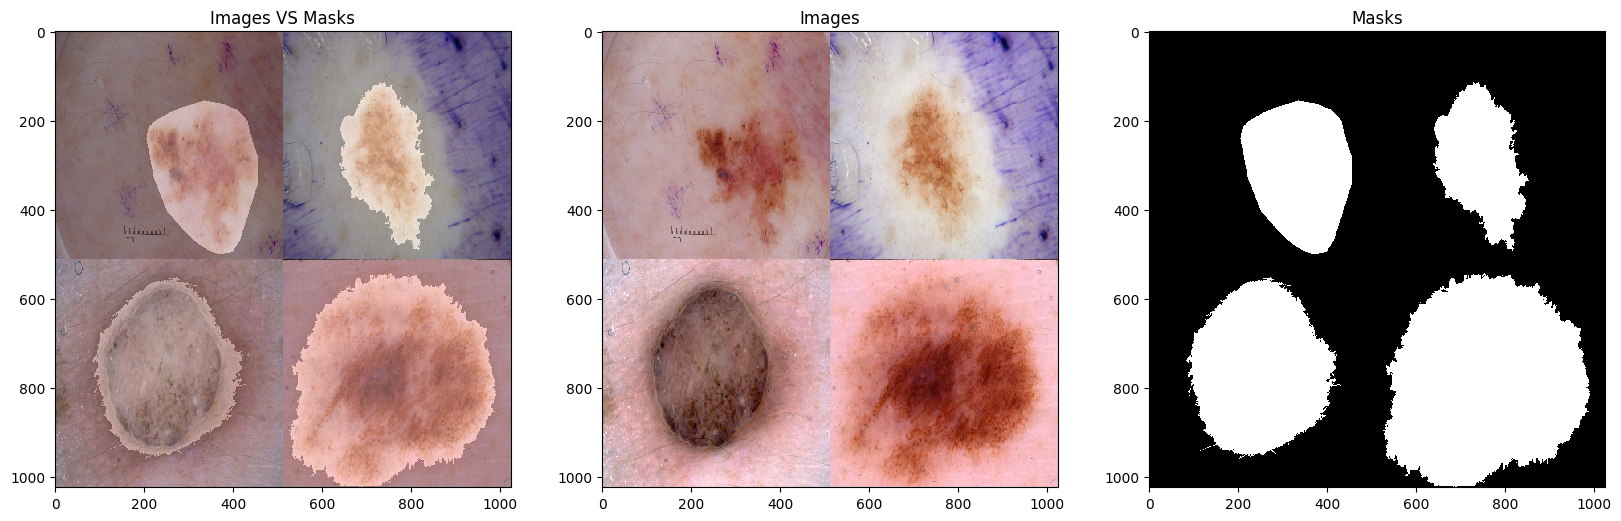

In [0]:
probe_image, probe_mask = next(test_generator)

print('image', probe_image.shape, probe_image.dtype, probe_image.min(), probe_image.max())
print('mask', probe_mask.shape, probe_mask.dtype, probe_mask.min(), probe_mask.max())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))

ax1.imshow(montage_rgb(probe_image)*0.5+0.5)
ax1.imshow(montage2d(probe_mask[:, :, :, 0]), cmap='gray',alpha=0.3)
ax1.set_title('Images VS Masks')

ax2.imshow(montage_rgb(probe_image)*0.5+0.5)
ax2.set_title('Images')

ax3.imshow(montage2d(probe_mask[:, :, :, 0]), cmap='gray')
ax3.set_title('Masks')

plt.show()

## Build the model

**import the necessary packages**

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Concatenate, UpSampling2D, BatchNormalization, Dropout, Add

from keras.applications.vgg16 import VGG16

from model_utils import get_layer_size_dict, concat_layers_dict, save_log

**Loading the pretrained VGG16 network. This is our encoder part.**

In [0]:
VGG16_args = dict(input_shape = image_parameters['input_shape'], 
                  include_top = False, 
                  weights = 'imagenet')
log['VGG16_args'] = VGG16_args

vgg16 = VGG16(**VGG16_args)

58892288/58889256 [==============================] - 2s 0us/step


**Collect the layer sizes for the decoder part, inspect the structue of the pre-trained model**

In [0]:
layer_size_dict = get_layer_size_dict(vgg16)

for shape, layer_names in zip(layer_size_dict.keys(), layer_size_dict.values()):
    print('Otuput shape:', shape, 'Layer names:', [temp.name for temp in layer_names])

Otuput shape: (512, 512) Layer names: ['input_1', 'block1_conv1', 'block1_conv2']
Otuput shape: (256, 256) Layer names: ['block1_pool', 'block2_conv1', 'block2_conv2']
Otuput shape: (128, 128) Layer names: ['block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3']
Otuput shape: (64, 64) Layer names: ['block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3']
Otuput shape: (32, 32) Layer names: ['block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']
Otuput shape: (16, 16) Layer names: ['block5_pool']


In [0]:
concat_layers = concat_layers_dict(layer_size_dict)

for shape, output in zip(concat_layers.keys(), concat_layers.values()):
    print('Output shape: ', shape, 'Last output: ', output)

Output shape:  (512, 512) Last output:  Tensor("block1_conv2/Relu:0", shape=(?, 512, 512, 64), dtype=float32)
Output shape:  (256, 256) Last output:  Tensor("block2_conv2/Relu:0", shape=(?, 256, 256, 128), dtype=float32)
Output shape:  (128, 128) Last output:  Tensor("block3_conv3/Relu:0", shape=(?, 128, 128, 256), dtype=float32)
Output shape:  (64, 64) Last output:  Tensor("block4_conv3/Relu:0", shape=(?, 64, 64, 512), dtype=float32)
Output shape:  (32, 32) Last output:  Tensor("block5_conv3/Relu:0", shape=(?, 32, 32, 512), dtype=float32)
Output shape:  (16, 16) Last output:  Tensor("block5_pool/MaxPool:0", shape=(?, 16, 16, 512), dtype=float32)


**Build the decoder part**

In [0]:
encoder_output = vgg16.get_layer('block3_pool').output

# Bottle neck
##########################################################################

dilated_layers = []

x = Conv2D(512, (3, 3), padding='same', kernel_initializer ='he_normal')(encoder_output)
x = BatchNormalization()(x)
x = Activation('elu')(x)
dilated_layers.append(x)

x = Conv2D(512, (3, 3), padding='same', kernel_initializer ='he_normal', dilation_rate = 2)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
dilated_layers.append(x)

x = Conv2D(512, (3, 3), padding='same', kernel_initializer ='he_normal', dilation_rate = 4)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
dilated_layers.append(x)

x = Conv2D(512, (3, 3), padding='same', kernel_initializer ='he_normal', dilation_rate = 8)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
dilated_layers.append(x)

decoder_input = Add()(dilated_layers)

# Decoder
##########################################################################

x = UpSampling2D(size=(2,2))(decoder_input)
x = Conv2D(256, (3, 3), padding='same', kernel_initializer ='he_normal')(x)
x = Concatenate()([x, concat_layers[tuple(x.get_shape().as_list()[1:3])]])

x = Conv2D(256, (3, 3), padding='same', kernel_initializer ='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

##########################################################################

x = UpSampling2D(size=(2,2))(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = Concatenate()([x, concat_layers[tuple(x.get_shape().as_list()[1:3])]])

x = Conv2D(128, (3, 3), padding='same', kernel_initializer ='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

##########################################################################

x = UpSampling2D(size=(2,2))(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer ='he_normal')(x)
x = Concatenate()([x, concat_layers[tuple(x.get_shape().as_list()[1:3])]])

x = Conv2D(64, (3, 3), padding='same', kernel_initializer ='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

##########################################################################

x = Conv2D(32, (3, 3), padding='same', kernel_initializer ='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

x = Conv2D(1, (1, 1), padding='same', kernel_initializer ='he_normal')(x)
model_output = Activation('sigmoid')(x)

model_final = Model(inputs=vgg16.input, outputs=model_output)

In [0]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
from losses import dice_log_bce_loss
from keras.losses import binary_crossentropy

from metrics import dice, jaccard, precision, sensitivity, specificity

from callbacks import ProgeressPlot, ProgressSave
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, Callback, CSVLogger, CallbackList

from keras.optimizers import SGD, Adam, Nadam

In [0]:
save_dir = 'Final_solution/saved_models' + '/' + 'Unet_VGG16_dilated_convolutions_not_freezed'

# Set which layers can learn
for layer in vgg16.layers[1:]:
    layer.trainable = True

# Set callbacks
progress_save = ProgressSave(file_mode='w', save_dir=save_dir, filename='history.csv')

progress_plot = ProgeressPlot(next(test_generator), monitor='val_jaccard', save_dir=save_dir)

ReduceLROnPlateau_args = dict(monitor='val_jaccard',
                              mode='auto',
                              patience=2,
                              factor=0.5,
                              min_lr=0.000001,
                              verbose=1)
log['ReduceLROnPlateau_args'] = ReduceLROnPlateau_args
reduce_lr = ReduceLROnPlateau(**ReduceLROnPlateau_args)

checkpoint_path = save_dir + '/' + 'not_freezed' + '_{epoch:02d}_{val_loss:.3f}_{val_jaccard:.3f}.hdf5'
ModelCheckpoint_args = dict(monitor='val_jaccard',
                            save_best_only=True,  
                            save_weights_only = False,
                            mode='auto',
                            verbose=1)
log['ModelCheckpoint_args'] = ModelCheckpoint_args
checkpoint = ModelCheckpoint(checkpoint_path, **ModelCheckpoint_args)

EarlyStopping_args = dict(monitor='val_jaccard',
                          patience=10,
                          mode='auto',
                          verbose=1)
log['EarlyStopping_args'] = EarlyStopping_args
early = EarlyStopping(**EarlyStopping_args)

# Compile the model
adam = Adam(lr=0.0001)
complie_args = dict(optimizer = adam, 
                    loss = dice_log_bce_loss, 
                    metrics = [dice, jaccard, precision, sensitivity, specificity])
log['complie_args'] = complie_args
model_final.compile(**complie_args)

# Set fit_generator
fit_generator_args = dict(steps_per_epoch=len(train_df) // image_parameters['batch_size'],
                          validation_steps=len(valid_df) // image_parameters['batch_size'],
                          epochs=50,
                          initial_epoch = 0,
                          callbacks = [checkpoint, early, reduce_lr, progress_save, progress_plot])
log['fit_generator_args'] = fit_generator_args
save_log(save_dir, log)
history = model_final.fit_generator(train_generator, validation_data=valid_generator, **fit_generator_args)

ProgressSave: [INFO] Creating file...
Epoch 1/50
520/520 [==============================] - 2143s 4s/step - loss: 0.2220 - dice: 0.8272 - jaccard: 0.7314 - precision: 0.8472 - sensitivity: 0.8644 - specificity: 0.9674 - val_loss: 0.6109 - val_dice: 0.5899 - val_jaccard: 0.4703 - val_precision: 0.5042 - val_sensitivity: 0.9357 - val_specificity: 0.8116

Epoch 00001: val_jaccard improved from -inf to 0.47029, saving model to Final_solution/saved_models/Unet_VGG16_dilated_convolutions_not_freezed/not_freezed_01_0.611_0.470.hdf5
Saved predicted images.
Epoch 2/50
520/520 [==============================] - 1267s 2s/step - loss: 0.2173 - dice: 0.8288 - jaccard: 0.7332 - precision: 0.8454 - sensitivity: 0.8676 - specificity: 0.9681 - val_loss: 0.5532 - val_dice: 0.5940 - val_jaccard: 0.4678 - val_precision: 0.5269 - val_sensitivity: 0.8656 - val_specificity: 0.8465

Epoch 00002: val_jaccard did not improve from 0.47029
Epoch 3/50
520/520 [==============================] - 1261s 2s/step - loss

## Visualize the results

In [0]:
# load back the best weights
model_final.load_weights('Final_solution/saved_models/Unet_VGG16_dilated_convolutions_freezed' + '/' + "freezed_26_0.194_0.778.hdf5")

In [0]:
test_images, test_masks = next(test_generator)
test_predictions = model_final.predict(test_images)

print('Batch size:', test_images.shape[0])
for i in range(test_images.shape[0]):
    print('# in batch:', i+1, ', max, min value: ', test_predictions[i,:,:,:].max(), test_predictions[i,:,:,:].min())

Batch size: 4
# in batch: 1 , max, min value:  1.0 1.14958674e-07
# in batch: 2 , max, min value:  1.0 6.110436e-07
# in batch: 3 , max, min value:  1.0 2.859063e-06
# in batch: 4 , max, min value:  1.0 4.443358e-06


In [0]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (40, 10))

ax1.imshow(montage_rgb(test_images)*0.5+0.5)
ax1.imshow(montage2d(test_predictions[:, :, :, 0]), cmap='gray', alpha=0.3)
ax1.set_title('Image VS prediction');

contours_masks = find_contours(montage2d(test_masks[:, :, :, 0]), level=0.99)
for contour in contours_masks:
  ax1.plot(contour[:, 1], contour[:, 0], "--r", linewidth=0.5)

contours_predictions = find_contours(montage2d(test_predictions[:, :, :, 0]), level=0.9)
for contour in contours_predictions:
  ax1.plot(contour[:, 1], contour[:, 0], "--b", linewidth=0.5)
  
ax2.imshow(montage_rgb(test_images)*0.5+0.5)
ax2.set_title('Original images');
  
ax3.imshow(montage2d(test_predictions[:, :, :, 0]), cmap = 'gray')
ax3.set_title('Predictions');

ax4.imshow(montage2d(test_masks[:, :, :, 0]), cmap = 'gray')
ax4.set_title('Original Masks');

Output hidden; open in https://colab.research.google.com to view.

## Test the model on test data

**Get the best model checkpoint files**

In [0]:
root = 'Final_solution/saved_models'
directory = 'Unet_VGG16_dilated_convolutions_freezed'
filename = 'freezed_26_0.194_0.778.hdf5'

save_file_freezed_directory = os.path.join(root, directory)
save_file_freezed_path = os.path.join(save_file_freezed_directory, filename)

root = 'Final_solution/saved_models'
directory = 'Unet_VGG16_dilated_convolutions_not_freezed'
filename = 'not_freezed_24_0.179_0.790.hdf5'

save_file_not_freezed_directory = os.path.join(root, directory)
save_file_not_freezed_path = os.path.join(save_file_not_freezed_directory, filename)

**Evaluate goal metrics on test data**

In [0]:
from eval_utils import soft_jaccard, soft_jaccard_threshold, hard_jaccard, hard_jaccard_threshold
from keras.models import load_model
from keras.optimizers import Adam

In [0]:
model_final = load_model(save_file_not_freezed_path, compile=False)

adam = Adam(lr=0.0001)
model_final.compile(optimizer = adam, 
                    loss = dice_log_bce_loss, 
                    metrics = [soft_jaccard, soft_jaccard_threshold, hard_jaccard, hard_jaccard_threshold])

In [0]:
results = model_final.evaluate_generator(test_generator, steps=test_df.shape[0] // image_parameters['batch_size'], verbose=1)

for k,v in zip(model_final.metrics_names, results):
    print(k,'%2.4f' % v)

62/62 [==============================] - 245s 4s/step
loss 0.1703
soft_jaccard 0.7981
soft_jaccard_threshold 0.7239
hard_jaccard 0.8073
hard_jaccard_threshold 0.7305


**Plot the history**

In [0]:
result_freezed_df = pd.read_csv(os.path.join(save_file_freezed_directory, 'history.csv'))
result_not_freezed_df = pd.read_csv(os.path.join(save_file_not_freezed_directory, 'history.csv'))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


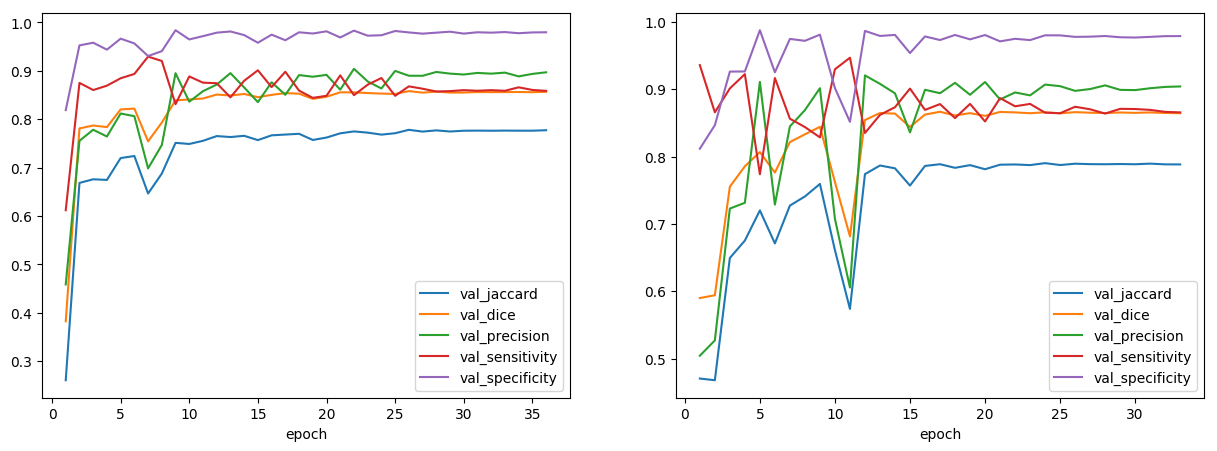

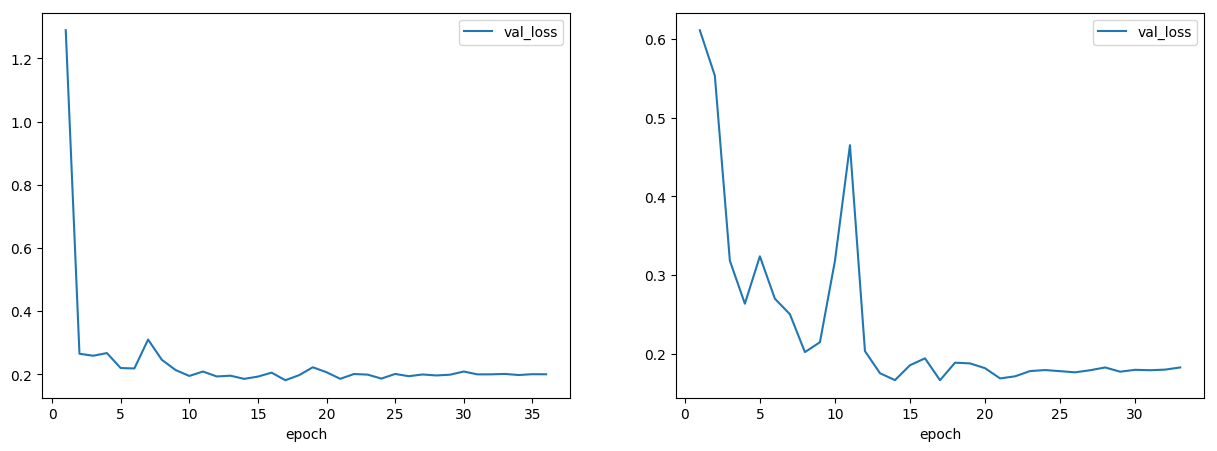

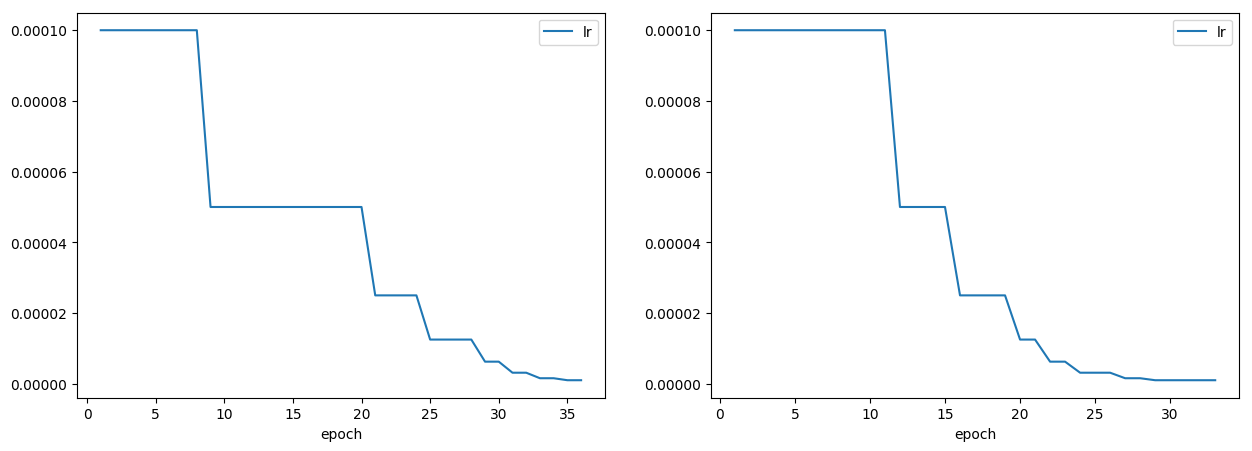

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

result_freezed_df.plot(x = 'epoch', y = ['val_jaccard', 'val_dice', 'val_precision', 'val_sensitivity', 'val_specificity'], ax=ax1);
result_not_freezed_df.plot(x = 'epoch', y = ['val_jaccard', 'val_dice', 'val_precision', 'val_sensitivity', 'val_specificity'], ax=ax2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

result_freezed_df.plot(x = 'epoch', y = 'val_loss', ax=ax1);
result_not_freezed_df.plot(x = 'epoch', y = 'val_loss', ax=ax2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

result_freezed_df.plot(x = 'epoch', y = 'lr', ax=ax1);
result_not_freezed_df.plot(x = 'epoch', y = 'lr', ax=ax2);

## Test the loss functions

In [0]:
from keras.losses import binary_crossentropy
from losses import dice_log_bce_loss
from eval_utils import soft_jaccard, soft_jaccard_threshold, hard_jaccard, hard_jaccard_threshold
from metrics import dice, jaccard, precision, sensitivity, specificity

In [0]:
test_images, test_masks = next(test_generator)
test_predictions = model_final.predict(test_images)

y_pred = tf.convert_to_tensor(test_predictions, dtype=tf.float32)
y_true = tf.convert_to_tensor(test_masks, dtype=tf.float32)

In [0]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

In [0]:
def hard_jaccard_threshold(y_true, y_pred, threshold=0.65, pixel_threshold=0.7):

    y_pred = K.greater(y_pred, pixel_threshold)
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    y_true_abs = K.sum(y_true, axis=[1,2,3])
    y_pred_abs = K.sum(y_pred, axis=[1,2,3])
    union = y_true_abs + y_pred_abs - intersection
    jaccard_index = (intersection / union)
    
    temp = K.greater(jaccard_index, threshold)
    temp = K.cast(temp, 'float32')

    return (temp*jaccard_index), temp, jaccard_index


result = sess.run(hard_jaccard_threshold(y_true, y_pred))

print(result)

(array([0.93733454, 0.8901515 , 0.77291304, 0.9549443 ], dtype=float32), array([1., 1., 1., 1.], dtype=float32), array([0.93733454, 0.8901515 , 0.77291304, 0.9549443 ], dtype=float32))


In [0]:
def hard_jaccard(y_true, y_pred, pixel_threshold=0.7):

    y_pred = K.greater(y_pred, pixel_threshold)
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    y_true_abs = K.sum(y_true, axis=[1,2,3])
    y_pred_abs = K.sum(y_pred, axis=[1,2,3])
    union = y_true_abs + y_pred_abs - intersection
    jacard_index = (intersection / union)
    
    return jacard_index
  
result = sess.run(hard_jaccard(y_true, y_pred))

print(result)

[0.93733454 0.8901515  0.77291304 0.9549443 ]


In [0]:
result = sess.run(jaccard(y_true, y_pred))

print(result)

[0.92846084 0.8695071  0.7862567  0.9272945 ]


In [0]:
def soft_jaccard(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    y_true_abs = K.sum(y_true, axis=[1,2,3])
    y_pred_abs = K.sum(y_pred, axis=[1,2,3])
    union = y_true_abs + y_pred_abs - intersection
    jacard_index = (intersection / union)
    
    return jacard_index

result = sess.run(soft_jaccard(y_true, y_pred))

print(result)

[0.92846084 0.8695071  0.7862567  0.9272945 ]
